<center>
<img src="../data/logo.png" height="900"> 
</center>

В этой тетрадке мы построим пару доверительных интервалов для продуктовых метрик [гуглового мерчендайз магазина.](https://www.kaggle.com/c/ga-customer-revenue-prediction)


#  Продуктовые метрики 

In [2]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # стиль для графиков

Чтобы держать руку на пульсе бизнеса, нужно строить довольно много продуктовых метрик. Более того, нужно понимать насколько адекватно эти метрики построены и насколько сильно они могут колебаться. Мы в этой тетрадке рассмотрим два таких показателя: возвращаемость (retention) и среднюю выручку (revenue per user, RPU)

In [4]:
visits = pd.read_csv('../data/marketing_log.csv', sep='\t')

# изменим тип колонки с датой на время
visits['date'] = pd.to_datetime(visits["date"], format="%Y-%m-%d")

# отсортируем данные по дате 
visits.sort_values('date', inplace=True)

# сбросим индексирование таблики
visits.reset_index(drop=True, inplace=True)

print(visits.shape)
visits.head()

(177973, 5)


/var/folders/3h/vx956j092txb03j9vsrpt0m80000gn/T/ipykernel_55017/2411946361.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  visits = pd.read_csv('../data/marketing_log.csv', sep='\t')


,date,fullVisitorId,browser,deviceCategory,transactionRevenue
0,2016-08-05,377595677869445136,Chrome,desktop,NaN
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN


# 1. Число пользователей

Сколько людей пользуются в день, неделю, месяц?

In [5]:
day = visits.groupby('date').agg({'fullVisitorId': 'nunique'})
day.head()

,fullVisitorId
date,
2016-08-05,2492
2016-08-11,2446
2016-08-16,2619
2016-08-20,1555
2016-08-22,2352


Среднее число посетителей в день: 2355.8285714285716


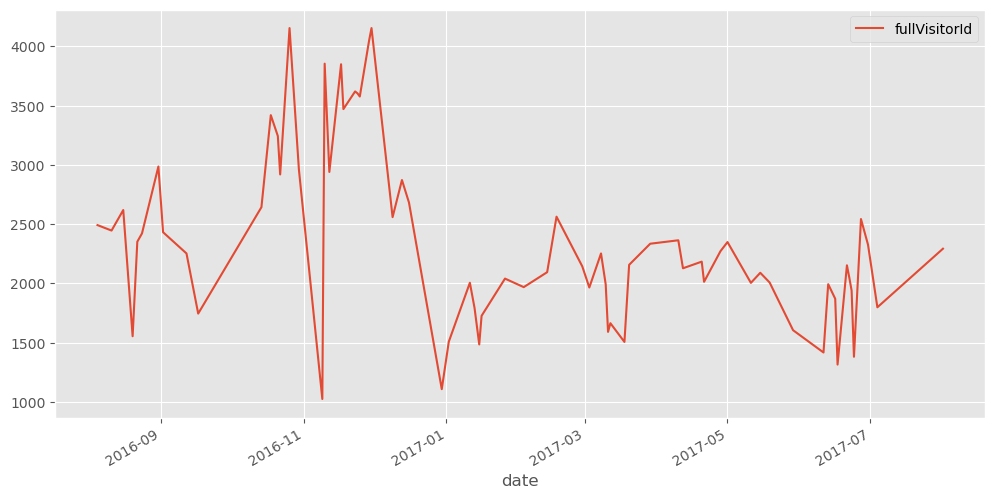

In [6]:
print(f"Среднее число посетителей в день: {day.fullVisitorId.mean()}")
day.sort_index().plot(figsize=(12,6));

# 2. Возвращаемость (retention)

Первый показатель, который обычно интересует бизнес это возвращаемость (retention): 

* `retention_1`  - вернулся ли игрок после **первого** дня с момента посещения магазина?
* `retention_7`  - вернулся ли игрок после **седьмого** дня с момента посещения магазина?

Заведём новую колонку: дата первого появления юзера.

In [7]:
first_visit = visits.groupby('fullVisitorId').agg({'date':'min'})
first_visit.columns = ['firstVisit']

visits = visits.join(first_visit, on='fullVisitorId')
visits.head()

,date,fullVisitorId,browser,deviceCategory,transactionRevenue,firstVisit
0,2016-08-05,377595677869445136,Chrome,desktop,NaN,2016-08-05
1,2016-08-05,7669007915434203149,Chrome,desktop,NaN,2016-08-05
2,2016-08-05,8513048163701118333,Chrome,desktop,NaN,2016-08-05
3,2016-08-05,8678920290726866310,Chrome,desktop,NaN,2016-08-05
4,2016-08-05,6522495992404435523,Chrome,desktop,NaN,2016-08-05


Ради интереса посмотрим на то, как распределено число дней между текущим и первым посещениями.

In [8]:
visits['daysFromFirstVisit'] = (visits.date - visits.firstVisit).apply(lambda w: w.days)

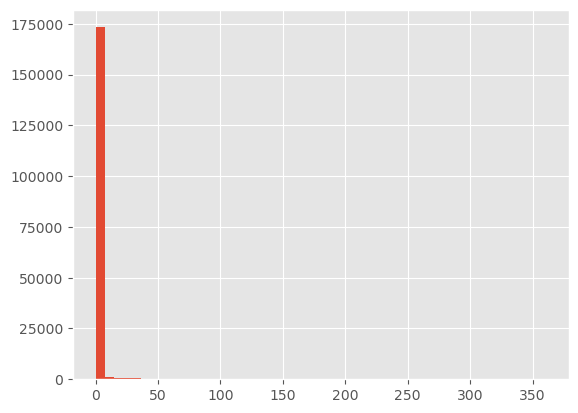

In [9]:
visits['daysFromFirstVisit'].hist(bins=50);

Видно, что чаще всего первое посещение оказывается последним.

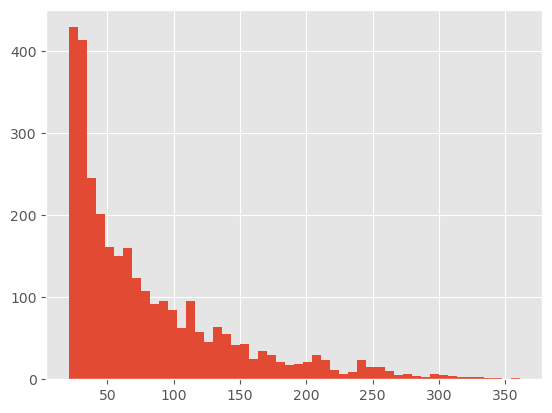

In [10]:
visits[visits['daysFromFirstVisit'] > 20]['daysFromFirstVisit'].hist(bins=50);

Найдём для каждого человека разность в днях между первым и последним посещениями: 

In [11]:
firsVisits = visits.groupby(['firstVisit', 'fullVisitorId']).agg({'daysFromFirstVisit': 'max'}).reset_index()
firsVisits.head()

,firstVisit,fullVisitorId,daysFromFirstVisit
0,2016-08-05,1000971553963693366,0
1,2016-08-05,1006834109386002658,0
2,2016-08-05,101246539776970727,0
3,2016-08-05,1013171119747358712,0
4,2016-08-05,1015220001673280213,0


In [12]:
visits.shape

(177973, 7)

In [13]:
firsVisits.shape

(159518, 3)

Как посчитать `retention_7`?  Если `daysFromFirstVisit` оказывается больше $7$, значит человек вернулся более, чем через $7$ дней после первого посещения. Такие люди нас и интересуют. Найдём их количество. 

In [14]:
retention = (
    firsVisits.groupby('firstVisit')['daysFromFirstVisit']
    .agg([ # больше 1 => вернулся хотябы через день
        ("success", lambda w: sum(w >= 7)),
        ("total", "count") # сколько всего людей зашли в эту дату
    ])
)

retention.head()

,success,total
firstVisit,,
2016-08-05,108,2492
2016-08-11,103,2413
2016-08-16,102,2543
2016-08-20,35,1532
2016-08-22,92,2234


Построим график. 

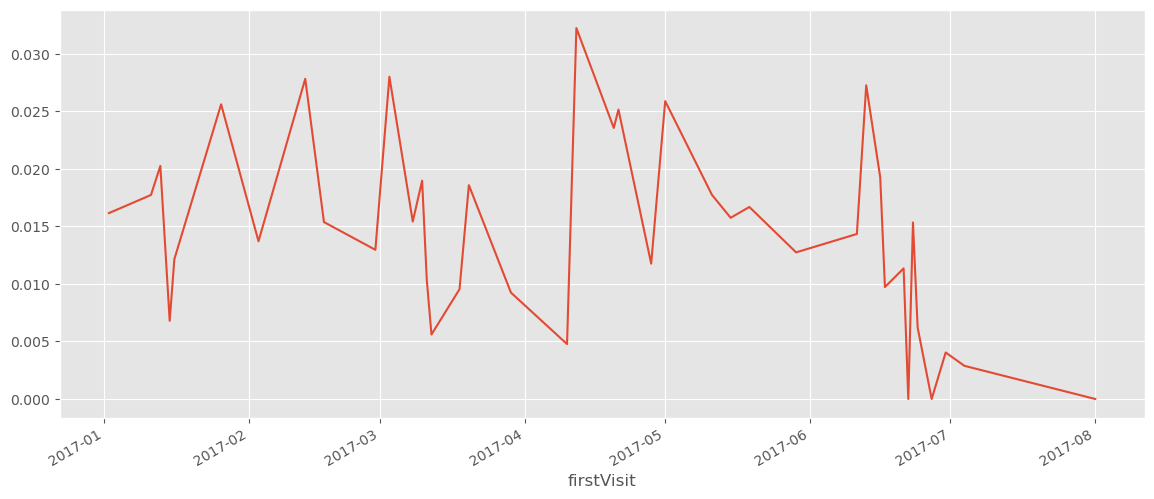

In [15]:
retention['retention'] = retention['success']/retention['total']
retention['retention'][30:120].plot(figsize=(14,6));

Есть много точечных оценок доли людей, которая возвращается для каждой даты. Но этого мало, каждая точка строится по разному числу наблюдений и нам хотелось бы понимать насколько оценка точная. Возвращаемость - это доля. Значит можно построить для неё доверителльный интервал с помощью ЦПТ:

$$
\hat p \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat p \cdot (1 - \hat p)}{n}} 
$$

In [16]:
retention.head()

,success,total,retention
firstVisit,,,
2016-08-05,108,2492,0.043339
2016-08-11,103,2413,0.042685
2016-08-16,102,2543,0.040110
2016-08-20,35,1532,0.022846
2016-08-22,92,2234,0.041182


In [17]:
alpha = 0.05

# стандартная ошибка
retention['se'] = np.sqrt(retention['retention'] * (1 - retention['retention']) / retention['total'])

# границы интервалов
q = stats.norm.ppf(1 - alpha/2)
retention['left'] = retention['retention'] - q * retention['se']
retention['right'] = retention['retention'] + q * retention['se']

retention.head()

,success,total,retention,se,left,right
firstVisit,,,,,,
2016-08-05,108,2492,0.043339,0.004079,0.035344,0.051333
2016-08-11,103,2413,0.042685,0.004115,0.034620,0.050751
2016-08-16,102,2543,0.040110,0.003891,0.032484,0.047736
2016-08-20,35,1532,0.022846,0.003817,0.015364,0.030328
2016-08-22,92,2234,0.041182,0.004204,0.032942,0.049422


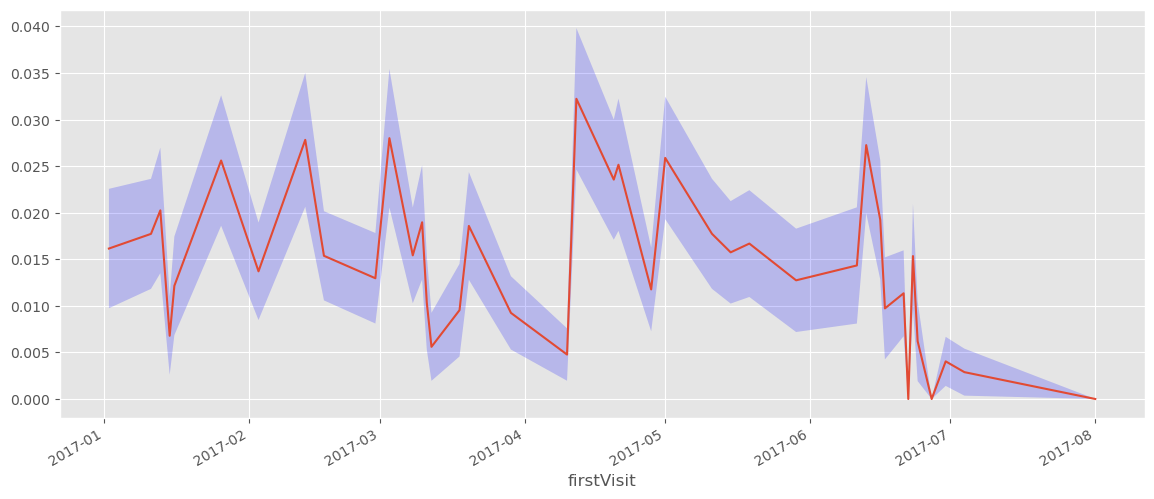

In [18]:
df = retention[30:120]

df['retention'].plot(figsize=(14,6))
plt.fill_between(df.index, df['left'], df['right'], facecolor='blue', alpha=0.2, interpolate=True)
plt.show()

# 3. Средний доход с пользователя (RPU)

Посмотрим как часто люди покупают.

In [19]:
# Процент покупок 
100*(1 - visits['transactionRevenue'].isnull().sum()/visits.shape[0])

1.3091873486427708

Всего лишь в $1\%$ случаев. Это очень редко, но с этой правдой жизни ничего не поделаешь. Оставим только тех, кто правда что-то покупал.

In [20]:
# будем строить RPU на месячной основе
visits['month'] = visits['date'].apply(lambda w: w.strftime('%Y-%m'))

purchases = visits.dropna(subset=['transactionRevenue'])
purchases.shape

(2330, 8)

Посмотрим на распределение стоимостей покупок.

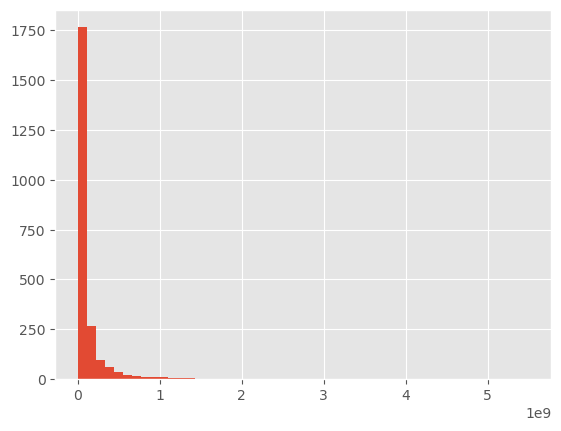

In [21]:
purchases['transactionRevenue'].hist(bins=50);

Видим, что есть выбросы. Удалим их из выборки. Для того, что применять ЦПТ, мы предполагаем, что ни одна случайная величина из выборки не выделяется на фоне остальных. 

In [22]:
q99 = purchases['transactionRevenue'].quantile(0.99)
q99

1194364900.0000002

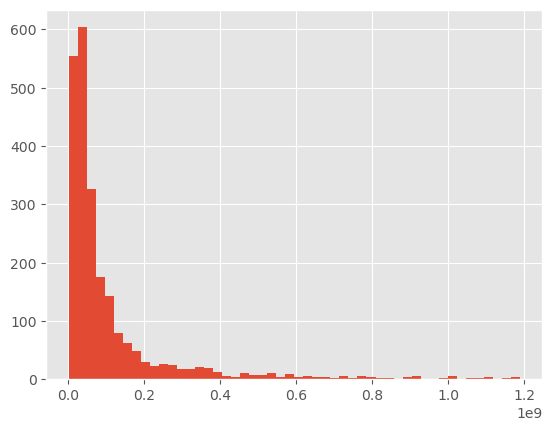

In [23]:
purchases = purchases[purchases['transactionRevenue'] < q99]
purchases['transactionRevenue'].hist(bins=50);

Посчитаем среднее, стандартное отклонение и число наблюдений для каждого месяца. 

In [24]:
datePurchases = (
    visits.groupby(['month'])['transactionRevenue']
    .agg([('rpu', 'mean'),
          ('count', 'count'),
          ('se', 'std')])
    .reset_index()
)

In [25]:
datePurchases.head()

,month,rpu,count,se
0,2016-08,1.403108e+08,302,2.576639e+08
1,2016-09,1.596071e+08,63,2.466225e+08
2,2016-10,1.495286e+08,154,2.847047e+08
3,2016-11,1.582393e+08,298,3.637715e+08
4,2016-12,1.078180e+08,249,2.386044e+08


Наконец, воспользуемся формулой для строительства доверительного интервала для среднего: 

$$
\hat \mu \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{\hat{\sigma}^2}{n}} 
$$

In [26]:
alpha = 0.05

# границы интервалов
q = stats.norm.ppf(1 - alpha/2)
datePurchases['left'] = datePurchases['rpu'] - q * datePurchases['se']/np.sqrt(datePurchases['count'])
datePurchases['right'] = datePurchases['rpu'] + q * datePurchases['se']/np.sqrt(datePurchases['count'])

datePurchases.tail()

,month,rpu,count,se,left,right
8,2017-04,1.112212e+08,221,2.348075e+08,8.026381e+07,1.421785e+08
9,2017-05,9.395333e+07,216,1.220328e+08,7.767920e+07,1.102275e+08
10,2017-06,1.163418e+08,307,3.751088e+08,7.438173e+07,1.583019e+08
11,2017-07,5.428286e+07,7,1.379814e+07,4.406124e+07,6.450447e+07
12,2017-08,1.931381e+08,43,4.787008e+08,5.005845e+07,3.362178e+08


Изобразим динамику RPU выручки на графике: 

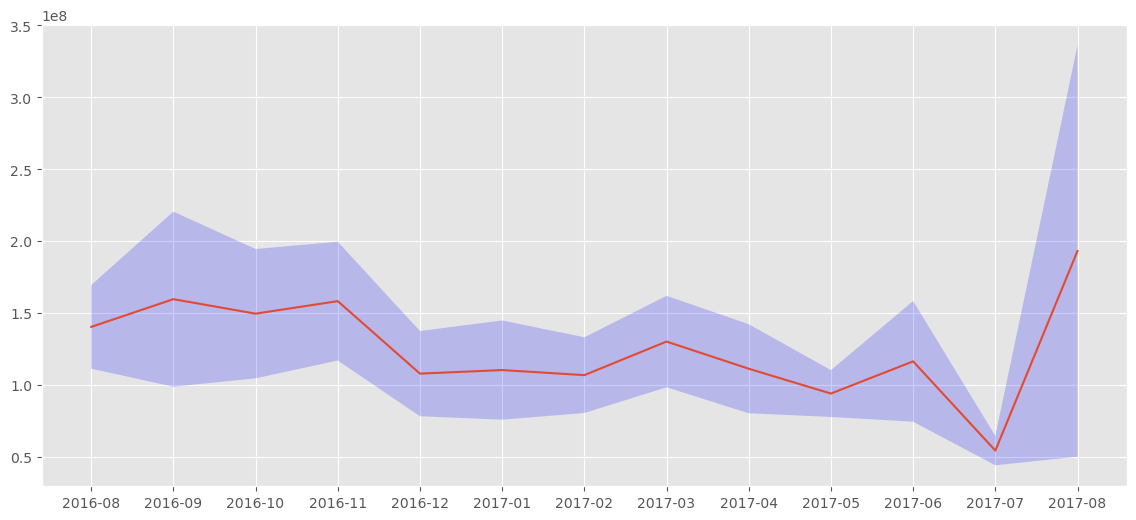

In [27]:
datePurchases['rpu'].plot(figsize=(14,6))
plt.fill_between(datePurchases['month'], datePurchases['left'], datePurchases['right'], 
                 facecolor='blue', alpha=0.2, interpolate=True)
plt.show()